# "Into the INFERNO: parameter estimation under uncertainty - Part 2"
> "In this series of posts, we'll be looking at one of the most common problems in high-energy physics; that of estimating some parameter of interest. In this second post we'll extend the framework from last time to see what happens when multiple regions of the data-space are considered."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [statistics, HEP, INFERNO]
- image: images/copied_from_nb/imgs/inferno/binning.png
- hide: false
- search_exclude: true

![binning comparison](imgs/inferno/binning.png)

Welcome back to the second part of this blog-post series. In case you missed it, the first part may be found [here](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/04/inferno-1.html). Last time we introduced the basic statistical framework for estimating parameters, and in this part we will expand on it to see how we can improve the precision of our measurements by considering multiple regions of the data-space.

Whilst I had said that we would begin looking at the paper this time, given some nice feedback I got from the previous post, I thought I'd spend a bit more time detailing a few more concepts, on the off chance that these posts are of more general use to people.

## Defining the data-space

In [17]:
# hide
%matplotlib inline
import matplotlib.pyplot as plt
from fastcore.all import is_listy
from typing import List, Optional, Tuple
from scipy.interpolate import InterpolatedUnivariateSpline
import numpy as np

import torch
from torch import Tensor, autograd, distributions

def plot_nlls(nlls:List[Tensor], mu_scan:Tensor, labels:Optional[List[str]]=None) -> List[float]:
    if not is_listy(nlls): nlls = [nlls]
    if labels is None: labels = ['' for _ in nlls]
    elif not is_listy(labels): labels = [labels]
    
    widths = []
    plt.figure(figsize=(16,9))
    plt.plot(mu_scan,[1 for _ in mu_scan], linestyle='--', color='black')
    for nll,lbl in zip(nlls,labels):
        dnll = nll-nll.min()  # Shift nll to zero
        roots = InterpolatedUnivariateSpline(mu_scan, dnll-1).roots()  # Interpolate to find crossing points at dll=1
        if len(roots) < 2: widths.append(np.nan)  # Sometimes the dnll doesn't cross 1
        else:              widths.append((roots[1]-roots[0])/2)  # Compute half the full width (uncertainty on mu)
        plt.plot(mu_range, dnll, label=f'{lbl} Width={widths[-1]:.2f}')
    plt.legend(fontsize=16)
    plt.xlabel('$\mu$', fontsize=24)
    plt.ylabel('$\Delta (-\ln L)$', fontsize=24)
    plt.show()
    
    return widths

First let's look at an interesting effect. Last time we kept the background, *b*, and observed count, *n* constant, but what happens if we adjust the data space that we observe? Let's keep the optimal signal strength at 100 (i.e. $n=100+b$), and adjust the level of background.

In [2]:
def compute_nll(mu:Tensor, b:float, n:float) -> Tensor:
    t_exp = mu+b
    return -torch.distributions.Poisson(t_exp).log_prob(n)

In [3]:
mu_range = torch.linspace(0,200, 50)
nlls,labels = [],[]
for b in [500,1000,1500]:
    nlls.append(compute_nll(mu_range, b=b, n=b+100))
    labels.append(f'b={b}, '+r'$\frac{s}{\sqrt{b}}=$'+f'{100/np.sqrt(b):.2f},')

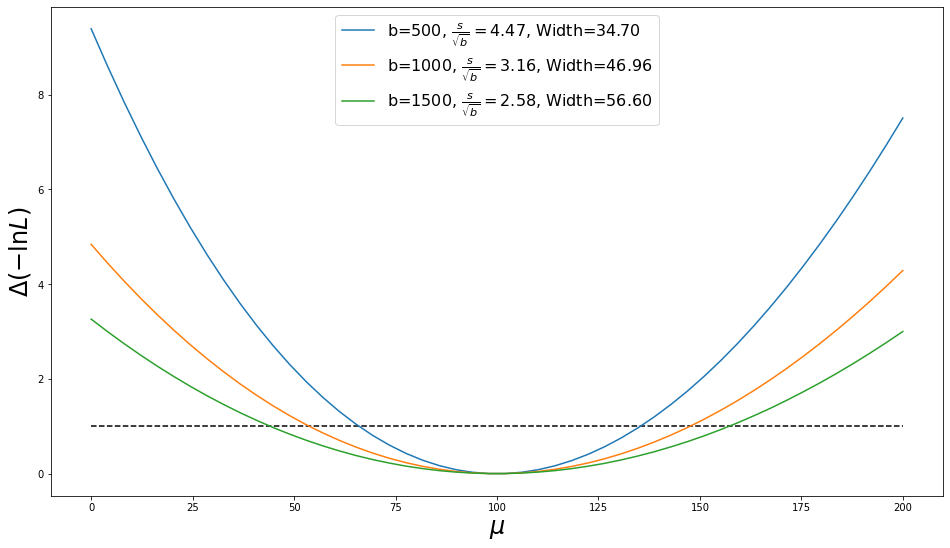

In [4]:
_ = plot_nlls(nlls, mu_range, labels)

So, improving the ratio of signal to background directly leads to an improvement in the precision of our estimate for $\mu$, the signal strength. The challenge, then is to find a region of the data-space where a lot of signal is present, and as little background contamination as possible.
The data-space can parameterised in terms of *features* describing the data. To visualise this, let's imagine the case of a feature in which the signal is mainly concentrated about a particular value, and the background is uniform:

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


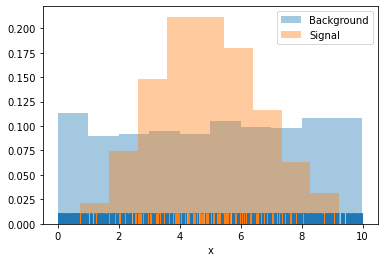

In [20]:
import seaborn as sns

nb = 1000
ns = 100

s = np.random.normal(5, 1.5, ns)
b = np.random.uniform(0, 10, nb)

def plot_data(s:np.ndarray, b:np.ndarray) -> None:
    sns.distplot(b,label='Background',hist=True,kde=False,rug=True,hist_kws={'density':True})
    sns.distplot(s,label='Signal',hist=True,kde=False,rug=True,hist_kws={'density':True})
    plt.xlabel('x')
    plt.legend()
    plt.show()
    
plot_data(s,b)

Now, if we simply take the data-space as is, then we end up counting all the signal and all the background. If, however, we take advantage of the differences in shape (*density*) of the signal and background, then we can work to optimise the ratio of signal to background, and so improve the precision of our measurement.

As an example, if we were to only consider data falling in the region $2\leq x\leq8$, then we would have a much better signal-background ratio, than if we were to consider the whole data-space

Ratio without cut 0.1, with cut 0.16


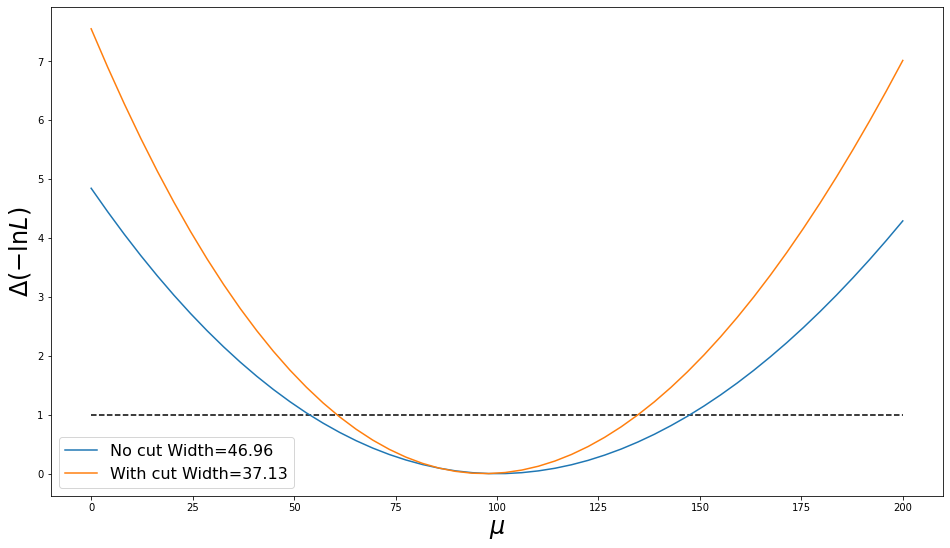

Fractional uncertainty without cut = 47.0%, with cut = 38.3%


In [6]:
cut_s = s[(2<=s)*(s<=8)]
cut_b = b[(2<=b)*(b<=8)]
print(f'Ratio without cut {len(s)/len(b)}, with cut {len(cut_s)/len(cut_b):.2f}')

nlls,labels = [],[]
nlls.append(compute_nll(mu_range, b=nb, n=nb+ns))
labels.append(f'No cut')
nlls.append(compute_nll(mu_range, b=len(cut_b), n=len(cut_b)+len(cut_s)))
labels.append(f'With cut')

widths = plot_nlls(nlls, mu_range, labels)
print(f'Fractional uncertainty without cut = {widths[0]/ns*100:.1f}%, with cut = {widths[1]/len(cut_s)*100:.1f}%')

So by carefully cutting away some of the data, we can improve the measurement. There was a slight shift in the optimal signal rate because we also cut away some expected signal. This data, however, is usually the result of an expensive and time-consuming process, and we don't want to just throw it away without making the most of it!

A more efficient approach is to combine two measurements: one on the data inside the cut, and the other on data outside it. To do this we need to refine the nll calculation slightly, in order to correctly split $\mu$ between these to regions.

In [7]:
outsidecut_s = s[(2>s)+(s>8)]
outsidecut_b = b[(2>b)+(b>8)]

# Compute the fraction of signal and background falling in each data region
s_shape = Tensor((len(cut_s), len(outsidecut_s)))
s_shape /= s_shape.sum()
b_shape = Tensor((len(cut_b), len(outsidecut_b)))
b_shape /= b_shape.sum()

n = Tensor((len(cut_b)+len(cut_s), len(outsidecut_b)+len(outsidecut_s)))
s_shape.sum(), b_shape.sum(), n.sum()

(tensor(1.), tensor(1.), tensor(1100.))

In [8]:
def compute_nll(mu:Tensor, s_shape:Tensor, b_shape:Tensor, n:Tensor, b:float) -> Tensor:
    t_exp = (mu[:,None]*s_shape)+(b*b_shape)  # The expected count in each data region
    nll = -torch.distributions.Poisson(t_exp).log_prob(n)
    return nll.sum(1)

Note the `nll.sum` above. As per Eq.6 in [Asymptotic formulae for likelihood-based tests of new physics](https://arxiv.org/abs/1007.1727), the likelihood should be the product of the Poisson probabilities, however we are working with the log probabilities, so instead we just sum them ($\log(10*20)=\log(10)+\log(20)$).

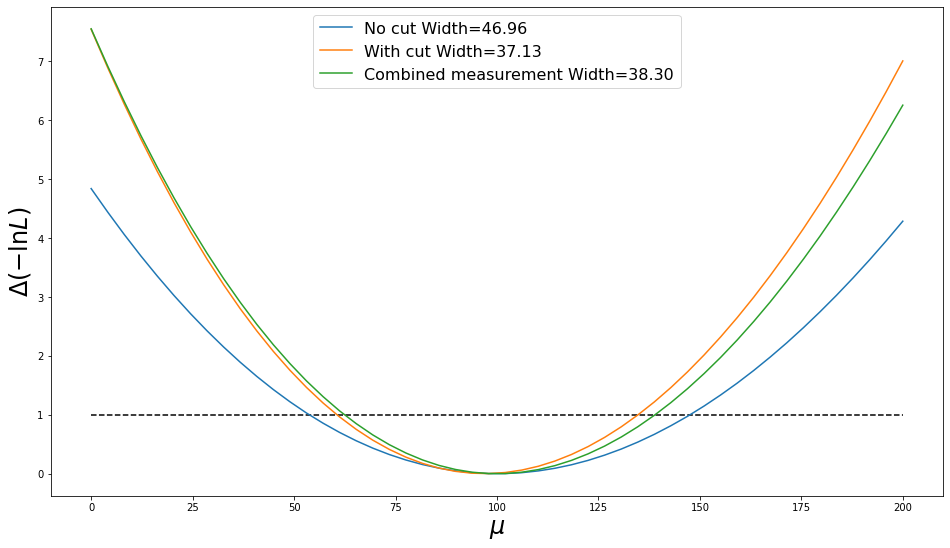

Fractional uncertainty with cut = 38.3%, combined 37.1%


In [10]:
nlls.append(compute_nll(mu_range, s_shape=s_shape, b_shape=b_shape, n=n, b=nb))
labels.append(f'Combined measurement')

widths = plot_nlls(nlls, mu_range, labels)
print(f'Fractional uncertainty with cut = {widths[1]/len(cut_s)*100:.1f}%, combined {widths[1]/ns*100:.1f}%')

The combination of measurements further improves the precision of our measurement beyond what we get simply from the measurement inside the cut region.

This approach can be referred to as *binning* the data-space in terms of some variable. And we are not limited to just two bins, we can have as many as want:

In [11]:
import math

def bin_data(s:np.ndarray, b:np.ndarray, n_bins:int) -> Tuple[Tensor,Tensor,Tensor]:
    edges = np.linspace(0,10,n_bins+1)
    edges[0] = -math.inf  # Ensure all the data end up in the bins
    edges[-1] = math.inf
    s_shape,b_shape = torch.zeros((n_bins)),torch.zeros((n_bins))

    for i in range(n_bins):
        s_shape[i] = len(s[(edges[i]<=s)*(s<=edges[i+1])])
        b_shape[i] = len(b[(edges[i]<=b)*(b<=edges[i+1])])

    n = s_shape+b_shape
    
    s_shape += 1e-7  # Ensure that every bin has some fill to avoid NaNs and Infs
    b_shape += 1e-7
    s_shape /= s_shape.sum()  # Normalise to get the fractional fill (shape)
    b_shape /= b_shape.sum()
    
    return s_shape, b_shape, n

In [12]:
n_bins = 5
s_shape, b_shape, n = bin_data(s,b,n_bins=n_bins)

In [13]:
nll = compute_nll(mu_range, s_shape=s_shape, b_shape=b_shape, n=n, b=nb)

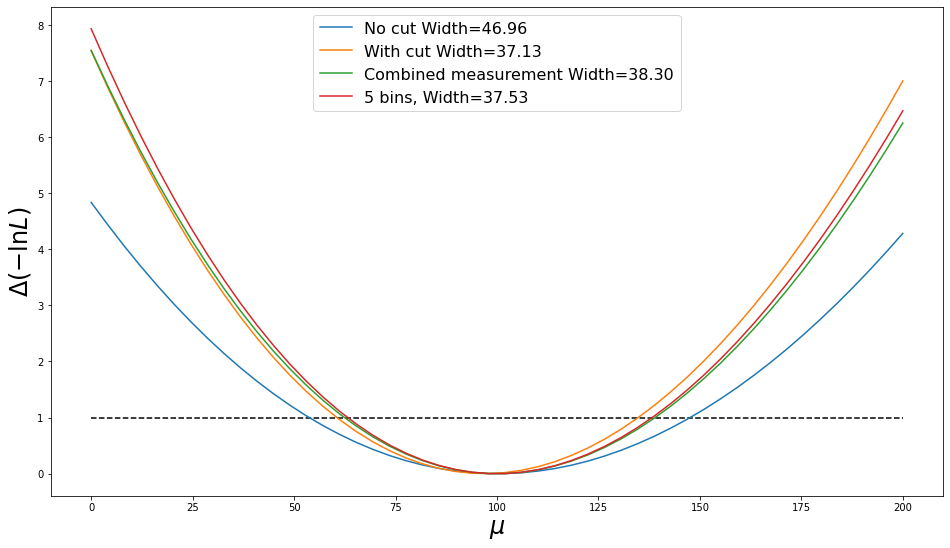

In [14]:
nlls.append(compute_nll(mu_range, s_shape=s_shape, b_shape=b_shape, n=n, b=nb))
labels.append(f'{n_bins} bins,')

_ = plot_nlls(nlls, mu_range, labels)

## Choice of feature

So we have seen that binning the data in terms of a feature can improve our measurement, but what about if we have several features to choose from? Let's look at a second example feature with slightly poorer separation:

In [15]:
def get_example(b_mean:float) -> Tensor:
    s = np.random.normal(5, 1.5, ns)
    b = np.random.normal(b_mean, 1.5, nb)

    plot_data(s,b)

    s_shape, b_shape, n = bin_data(s,b,n_bins=5)

    return compute_nll(mu_range, s_shape=s_shape, b_shape=b_shape, n=n, b=nb)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


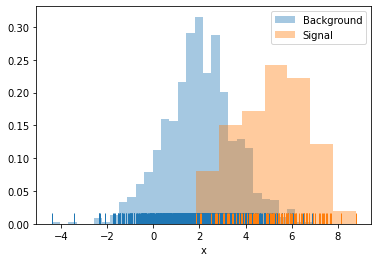

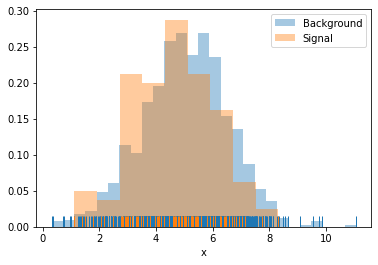

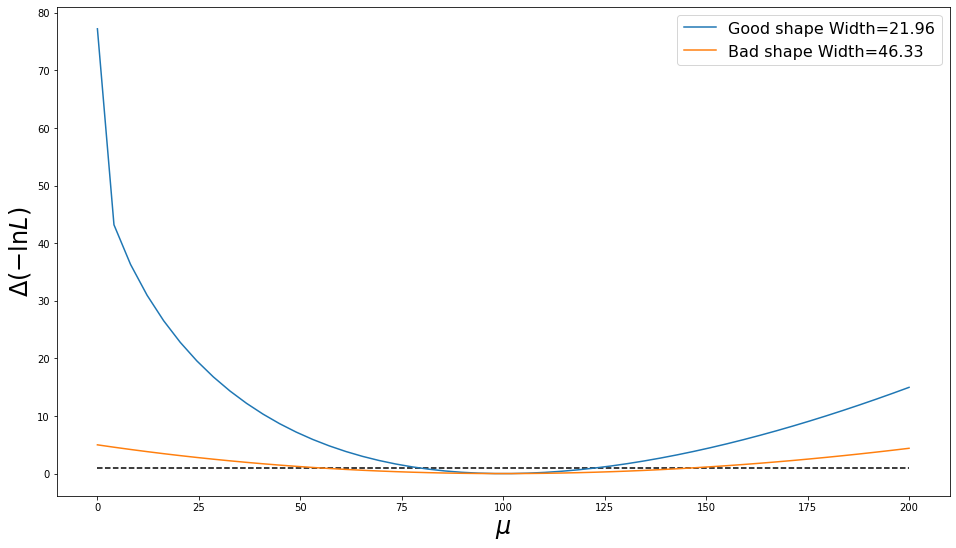

In [16]:
_ = plot_nlls([get_example(2),get_example(5)], mu_range, ['Good shape','Bad shape'])

In the first feature, the signal and background densities are well separated, however in the second, they overlap. Hopefully it's clear from this example this the choice of feature has a large effect on the precision of the measurement.

In HEP, and may other areas, there are many different features which can be computed to describe the data. Ideally we want to have a single feature in which the signal and background are most linearly separable, such that when it is binned, many of the bins display a large signal to background ratio. Next time we will look into how we can go about searching for such a feature.

## Closing

So, unfortunately we still didn't get to dealing with the INFERNO paper, but now that we've finished laying the groundwork and have introduced *most* of the required concepts, we should be able to move onto the paper in the next post.

### Asimov dataset

One subtlety that you may have noticed, is last time we were evaluating the log probability we used the number of observed data. In this post I have assumed that the observed count (per bin) is equal to the expected signal and background contributions (in each bin).

In HEP, we often perform analyses *blind*, meaning that we only work with simulated data until the entire analysis is fixed in place, and all optimisation has been performed. Only then do we look at the real data. I.e. we only know the observed counts right at the very end of the analysis. As we have seen, though, various choices, such as the feature used, and the binning procedure can have huge influences on the performance of the analysis. Therefore it is useful to have some idea of the observed count to allow us to compute the expected precision and so optimise the analysis.

As discussed in [Asymptotic formulae for likelihood-based tests of new physics](https://arxiv.org/abs/1007.1727), a suitable substitute for the observed count is the sum of the expected contributions from signal and background in which the nuisance parameters and parameter of interest are at their nominal values. This is referred to in the paper as the Asimov dataset. Remembering that the signal and background are Poisson processes, and so could be used to generate an infinite number of different expected datasets through sampling, by taking the expected yields, the Asimov dataset is the "single most representative dataset". The naming is inspired by the book Franchise by Isaac Asimov, in which the single most representative person is used to vote on behalf of an entire populace.